# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Loading Datasets

In [ ]:
train_data = pd.read_csv('/content/train_data_v3.csv')
test_data = pd.read_csv('/content/test_data_v3.csv')
validate_data = pd.read_csv('/content/validate_data_v3.csv')

train_data.info()
test_data.info()
validate_data.info()

train_data.head()
test_data.head()
validate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 69 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Wind_Direction_E                                  8000 non-null   float64
 1   Wind_Direction_ENE                                8000 non-null   float64
 2   Wind_Direction_ESE                                8000 non-null   float64
 3   Wind_Direction_East                               8000 non-null   float64
 4   Wind_Direction_N                                  8000 non-null   float64
 5   Wind_Direction_NE                                 8000 non-null   float64
 6   Wind_Direction_NNE                                8000 non-null   float64
 7   Wind_Direction_NNW                                8000 non-null   float64
 8   Wind_Direction_NW                                 8000 non-null   float64
 9   Wind_Direction_Nort

,Wind_Direction_E,Wind_Direction_ENE,Wind_Direction_ESE,Wind_Direction_East,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NNE,Wind_Direction_NNW,Wind_Direction_NW,Wind_Direction_North,...,Weather_Condition_Encoded,Weather_Condition_Fog / Low Visibility,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Severity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2021,1,29,20,2
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2022,12,5,16,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2020,3,17,14,3
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,0,0,1,0,2019,2,27,4,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2022,7,30,9,2


# Building Model

## Separate Target and Features

In [ ]:
X_train = train_data.drop(columns=['Severity'])
y_train = train_data['Severity']
X_test = test_data.drop(columns=['Severity'])
y_test = test_data['Severity']
X_validate = validate_data.drop(columns=['Severity'])
y_validate = validate_data['Severity']

## Scale Data

In [ ]:
# Scale the data before feature selection and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

##Base Model: Linear SVM

In [ ]:
param_grid = {
    'C': [0.1, 1, 5],  # Try different values of C
    'kernel': ['linear']  # Force it to only use linear kernel
}

In [ ]:
grid_search = GridSearchCV(
    SVC(),                # Base model
    param_grid,           # Hyperparameter grid
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Optimize for accuracy
    n_jobs=-1             # Use all cores
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5], 'kernel': ['linear']},
             scoring='accuracy')

In [ ]:
# Evaluate the best model on the test set
best_linear_svm = grid_search.best_estimator_
y_test_pred_balanced = best_linear_svm.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Best Linear SVM Model:", grid_search.best_params_)
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Best Linear SVM Model: {'C': 5, 'kernel': 'linear'}
Test Accuracy After Balancing: 0.327
Classification Report:
               precision    recall  f1-score   support

           1       0.02      0.50      0.03         6
           2       0.92      0.29      0.44       857
           3       0.24      0.54      0.34       119
           4       0.03      0.50      0.06        18

    accuracy                           0.33      1000
   macro avg       0.30      0.46      0.22      1000
weighted avg       0.82      0.33      0.42      1000



<Figure size 1000x800 with 0 Axes>

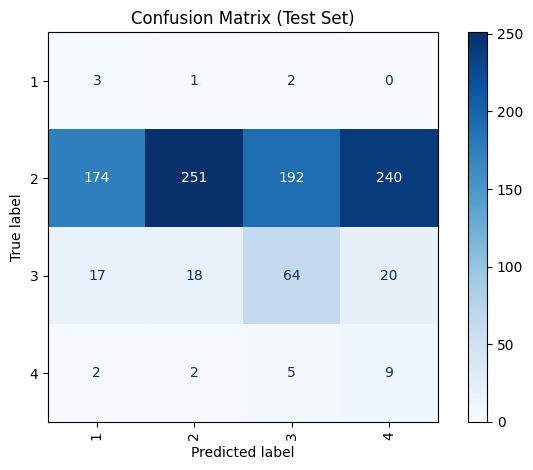

[[  3   1   2   0]
 [174 251 192 240]
 [ 17  18  64  20]
 [  2   2   5   9]]
acc1 (Exact match accuracy): 0.3270
acc2 (One-off accuracy): 0.7370


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_linear_svm, X_test_scaled, y_test,
                                      cmap='Blues',
                                      display_labels=best_linear_svm.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = best_linear_svm.predict(X_test_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

##SVM 2nd Model (kernel=rbf)

In [ ]:
svm_rbf = Pipeline([
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, C=5))
])
svm_rbf.fit(X_train_scaled, y_train)

Pipeline(steps=[('svm', SVC(C=5, class_weight='balanced', probability=True))])

In [ ]:
# Predict on validation set (for hyperparameter tuning)
y_validate_pred = svm_rbf.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = svm_rbf.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Validation Accuracy  0.429
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.07      0.86      0.14        14
           2       0.92      0.39      0.55       828
           3       0.30      0.65      0.41       124
           4       0.06      0.38      0.10        34

    accuracy                           0.43      1000
   macro avg       0.34      0.57      0.30      1000
weighted avg       0.80      0.43      0.51      1000

Test Accuracy After Balancing: 0.439
Classification Report:
               precision    recall  f1-score   support

           1       0.04      1.00      0.08         6
           2       0.92      0.43      0.58       857
           3       0.24      0.50      0.33       119
           4       0.03      0.39      0.06        18

    accuracy                           0.44      1000
   macro avg       0.31      0.58      0.26      1000
weighted avg       0.82      0.44      0.54      1000



<Figure size 1000x800 with 0 Axes>

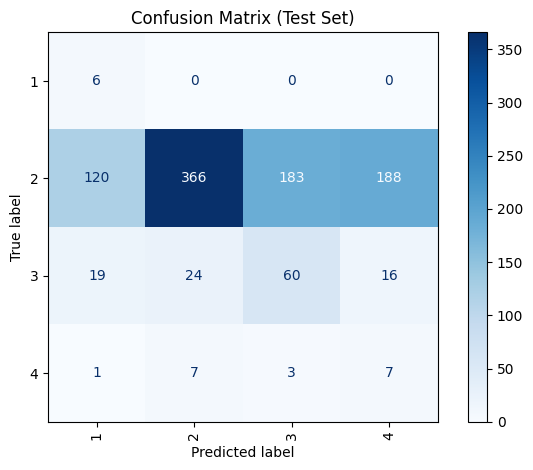

[[  6   0   0   0]
 [120 366 183 188]
 [ 19  24  60  16]
 [  1   7   3   7]]
acc1 (Exact match accuracy): 0.4390
acc2 (One-off accuracy): 0.7850


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(svm_rbf, X_test_scaled, y_test,
                                      cmap='Blues',
                                      display_labels=svm_rbf.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = svm_rbf.predict(X_test_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

## SVM 3rd Model (kernel = poly)

In [ ]:
svm_poly = Pipeline([
    ('svm', SVC(kernel='poly', class_weight='balanced', probability=True, C=5))
])
svm_poly.fit(X_train_scaled, y_train)

Pipeline(steps=[('svm',
                 SVC(C=5, class_weight='balanced', kernel='poly',
                     probability=True))])

In [ ]:
# Predict on validation set (for hyperparameter tuning)
y_validate_pred = svm_poly.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = svm_poly.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Validation Accuracy  0.376
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.05      0.71      0.10        14
           2       0.90      0.34      0.50       828
           3       0.26      0.52      0.35       124
           4       0.06      0.47      0.11        34

    accuracy                           0.38      1000
   macro avg       0.32      0.51      0.26      1000
weighted avg       0.78      0.38      0.46      1000

Test Accuracy After Balancing: 0.373
Classification Report:
               precision    recall  f1-score   support

           1       0.02      0.67      0.04         6
           2       0.92      0.36      0.51       857
           3       0.25      0.48      0.33       119
           4       0.03      0.39      0.05        18

    accuracy                           0.37      1000
   macro avg       0.30      0.47      0.23      1000
weighted avg       0.82      0.37      0.48      1000



<Figure size 1000x800 with 0 Axes>

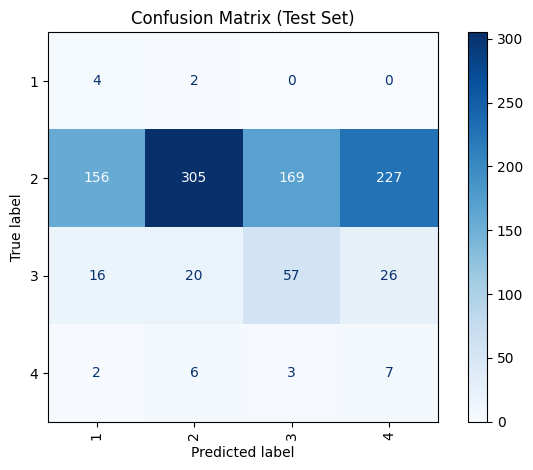

[[  4   2   0   0]
 [156 305 169 227]
 [ 16  20  57  26]
 [  2   6   3   7]]
acc1 (Exact match accuracy): 0.3730
acc2 (One-off accuracy): 0.7490


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(svm_poly, X_test_scaled, y_test,
                                      cmap='Blues',
                                      display_labels=svm_poly.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = svm_poly.predict(X_test_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

## Linear SVM with RFE (Recursive feature elimination)

In [ ]:
# SVM with RFE (Recursive Feature Elimination)
linear_svm = LinearSVC(C=5, max_iter=5000, class_weight='balanced')
rfe = RFE(estimator=linear_svm, n_features_to_select=20, step=1)  # Keep top 20 features
rfe.fit(X_train_scaled, y_train)

# Get the ranking of features and selected features
selected_features = rfe.support_
X_train_rfe = X_train_scaled[:, selected_features]
X_validate_rfe = X_validate_scaled[:, selected_features]
X_test_rfe = X_test_scaled[:, selected_features]

# Train SVM on selected features
svm_rfe = SVC(kernel='rbf', C=5, gamma=0.1, class_weight='balanced', probability = True)
svm_rfe.fit(X_train_rfe, y_train)

# Predict on validation set (for hyperparameter tuning)
y_validate_pred_rfe = svm_rfe.predict(X_validate_rfe)

# Evaluate performance on validation set
validate_accuracy_rfe = accuracy_score(y_validate, y_validate_pred_rfe)
validate_report_rfe = classification_report(y_validate, y_validate_pred_rfe)

# Print RFE results on validation set
print("Validation Accuracy After RFE:", validate_accuracy_rfe)
print("Classification Report After RFE (Validation Set):\n", validate_report_rfe)

# Evaluate the final model on the test set
y_test_pred_rfe = svm_rfe.predict(X_test_rfe)

# Evaluate performance on the test set
accuracy_rfe = accuracy_score(y_test, y_test_pred_rfe)
report_rfe = classification_report(y_test, y_test_pred_rfe)

# Print final results
print("Test Accuracy After RFE and Hyperparameter Tuning:", accuracy_rfe)
print("Classification Report After RFE (Test Set):\n", report_rfe)

Validation Accuracy After RFE: 0.462
Classification Report After RFE (Validation Set):
               precision    recall  f1-score   support

           1       0.08      0.79      0.15        14
           2       0.93      0.42      0.58       828
           3       0.29      0.69      0.41       124
           4       0.10      0.56      0.16        34

    accuracy                           0.46      1000
   macro avg       0.35      0.61      0.32      1000
weighted avg       0.81      0.46      0.54      1000

Test Accuracy After RFE and Hyperparameter Tuning: 0.456
Classification Report After RFE (Test Set):
               precision    recall  f1-score   support

           1       0.05      1.00      0.09         6
           2       0.94      0.43      0.59       857
           3       0.26      0.60      0.36       119
           4       0.04      0.44      0.07        18

    accuracy                           0.46      1000
   macro avg       0.32      0.62      0.28      

<Figure size 1000x800 with 0 Axes>

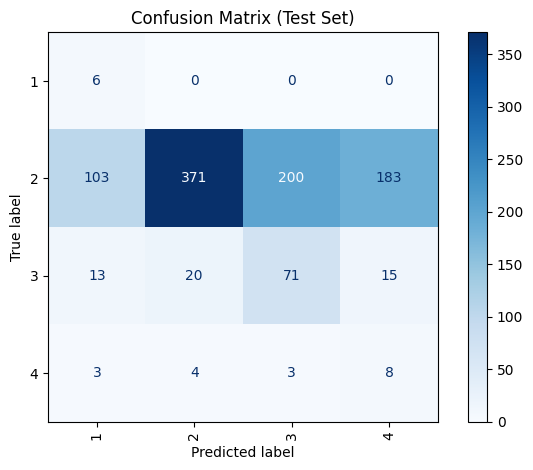

[[  6   0   0   0]
 [103 371 200 183]
 [ 13  20  71  15]
 [  3   4   3   8]]
acc1 (Exact match accuracy): 0.4560
acc2 (One-off accuracy): 0.7970


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(svm_rfe, X_test_rfe, y_test,
                                      cmap='Blues',
                                      display_labels=svm_rfe.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = svm_rfe.predict(X_test_rfe)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")